#### `I`mports


In [1]:
import numpy as np
import pandas as pd

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    cross_val_predict,
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    accuracy_score,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400


`L`oad Data


In [2]:
# Global Random State
np.random.seed(42)


In [3]:
df = pd.read_csv("../data/after_eda/reddit_data.csv")
df.shape


(12895, 20)

In [4]:
df["selftext"] = df["selftext"].fillna("")
df.isna().sum()


selftext                      0
title                         0
score                         0
domain                        0
id                            0
author                        0
num_comments                  0
url                           0
created_utc                   0
subreddit                     0
selftext_length               0
title_length                  0
title_word_count              0
selftext_word_count           0
selftext_emoji_count          0
title_emoji_count             0
subreddit_text                0
subreddit_text_length         0
subreddit_text_word_count     0
subreddit_text_emoji_count    0
dtype: int64

---

- Convert boardgames/wsb into binary labels


In [5]:
df["subreddit"] = df["subreddit"].map({"boardgames": 0, "wsb": 1})


---

- Setup data for modeling for `selftext`


In [6]:
X = df["subreddit_text"]
y = df["subreddit"]


- Baseline accuracy


In [7]:
y.value_counts(normalize=True)


1    0.571694
0    0.428306
Name: subreddit, dtype: float64

In [8]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42
)


---

`P`reprocessing and Modeling


In [9]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words=stopwords.words("english"))

# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train = cvec.transform(X_train)

X_test = cvec.transform(X_test)


In [10]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
X_train_df = pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names_out())

# plot top occuring words
X_train_df["boardgames_or_wsb"] = y_train.values


- Check top 20 words used between 2 `subreddits`


<AxesSubplot: >

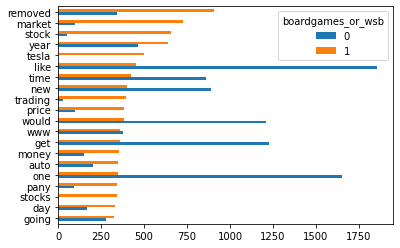

In [11]:
X_train_df.groupby("boardgames_or_wsb").sum().T.sort_values(1, ascending=True).tail(
    20
).plot.barh()


In [12]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42
)


---

`G`lobal Methods


In [13]:
def global_grid_search_cv(pipe, grid_params):
    """
    Initialize grid search cv with necessary hyper params
    """
    return GridSearchCV(pipe, grid_params, cv=5, n_jobs=-1)


def print_model_stats(gs, X_train, X_test, y_train, y_test):
    """
    Prints model performance
    """

    line_break = "\n--------------------------------\n"
    print(
        f"""
          {line_break}Model Best Score:\n\t{gs.best_score_}
          {line_break}Model Best Params:\n\t{gs.best_params_}
          {line_break}Model score:
            \n\tTrain: {round(gs.score(X_train, y_train)*100, 1)}%
            \n\tTest: {round(gs.score(X_test, y_test)*100, 1)}%
        {line_break}Misclassification Rate:
            \n\tTrain: {round((1 - gs.score(X_train, y_train))*100, 1)}%
            \n\tTest: {round((1 - gs.score(X_test, y_test))*100, 1)}%{line_break}
        """
    )


def plot_confusion_matrix(gs, y_test, y_preds):
    # View confusion matrix
    cm = confusion_matrix(y_test, y_preds)
    display = ConfusionMatrixDisplay(cm, display_labels=gs.classes_)
    display.plot()


def print_spec_sens(y_test, y_preds):
    """
    Prints model specificity and sensitivity
    """
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    spec = tn / (tn + fp)
    sens = tp / (tp + fn)
    print(f"Spec: {spec}\nSens: {sens}")


def print_confidence_interval(pred_cross, n):
    # 1.64 (90%)
    # 1.96 (95%)
    # 2.33 (98%)
    # 2.58 (99%)
    print(
        f"Confidence interval is : {round(pred_cross.mean()*100, 2)} \u00B1 {round(1.96*pred_cross.std()/n**0.5*100, 2)}"
    )


def print_classification_report(y_test, pred_cross):
    print(
        f"Classifier Report:\n{classification_report(y_test, pred_cross, labels=[1, 0])}"
    )


def run_stats(gs, X_train, X_test, y_train, y_test):
    y_pred = gs.predict(X_test)
    score_cross = cross_val_score(gs.best_estimator_, X_train, y_train, cv=5)
    pred_cross = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=5)

    print_model_stats(gs, X_train, X_test, y_train, y_test)

    print_classification_report(y_train, pred_cross)

    print_confidence_interval(score_cross, len(y_train))

    plot_confusion_matrix(gs, y_test, y_pred)
    print_spec_sens(y_test, y_pred)
    RocCurveDisplay.from_estimator(gs, X_test, y_test)


`N`aive Bayes Modeling


- Transformer: CountVectorizer


In [14]:
def naive_baye_model(X_train, y_train, vectorizer):
    pipe = Pipeline(
        [
            ("vec", vectorizer()),
            ("nb", MultinomialNB()),
        ]
    )

    pipe_params = {
        "vec__max_features": [2000, 3000, 4000, 5000],
        "vec__min_df": [2, 3],
        "vec__max_df": [0.9, 0.95],
        "vec__ngram_range": [(1, 1), (2, 2)],
        "vec__stop_words": [None, "english", stopwords.words("english")],
    }

    # Init grid
    gs = global_grid_search_cv(pipe, pipe_params)

    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)

    return gs


def run_naive_baye_model(X_train, y_train, vectorizer):
    gs_nb = naive_baye_model(X_train, y_train, CountVectorizer)

    return gs_nb


In [15]:
gs_nb_cvec = run_naive_baye_model(X_train, y_train, CountVectorizer)



          
--------------------------------
Model Best Score:
	0.9372606103497823
          
--------------------------------
Model Best Params:
	{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 3, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}
          
--------------------------------
Model score:
            
	Train: 94.4%
            
	Test: 92.8%
        
--------------------------------
Misclassification Rate:
            
	Train: 5.6%
            
	Test: 7.2%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.96      0.93      0.94      4939
           0       0.91      0.94      0.93      3700

    accuracy                           0.94      8639
   macro avg       0.93      0.94      0.94      8639
weighted avg       0.94      0.94      0.94      8639

Confidence interval is : 93.73 ± 0.01
Spec: 0.927591881513988
Sens: 0.9288943690916563


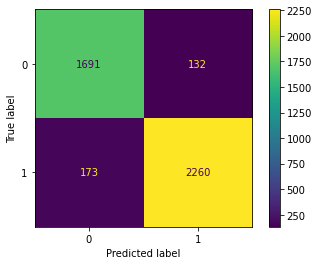

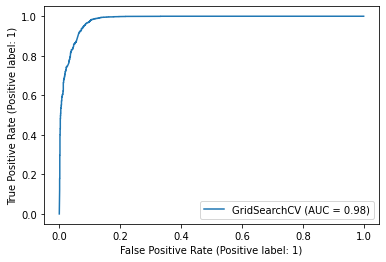

In [16]:
run_stats(gs_nb_cvec, X_train, X_test, y_train, y_test)


- Transformer: TfidVectorizer


In [17]:
gs_nb_tfvid = run_naive_baye_model(X_train, y_train, TfidfVectorizer)



          
--------------------------------
Model Best Score:
	0.9372606103497823
          
--------------------------------
Model Best Params:
	{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 3, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}
          
--------------------------------
Model score:
            
	Train: 94.4%
            
	Test: 92.8%
        
--------------------------------
Misclassification Rate:
            
	Train: 5.6%
            
	Test: 7.2%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.96      0.93      0.94      4939
           0       0.91      0.94      0.93      3700

    accuracy                           0.94      8639
   macro avg       0.93      0.94      0.94      8639
weighted avg       0.94      0.94      0.94      8639

Confidence interval is : 93.73 ± 0.01
Spec: 0.927591881513988
Sens: 0.9288943690916563


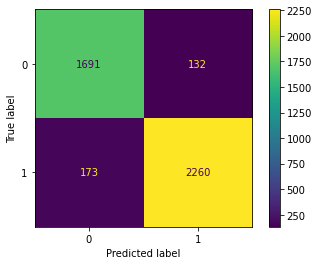

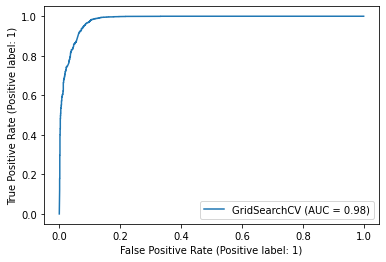

In [18]:
run_stats(gs_nb_tfvid, X_train, X_test, y_train, y_test)


`L`ogistic Regression Modeling


In [19]:
def log_reg_model(X_train, y_train, vectorizer):
    pipe = Pipeline(
        [
            ("vec", vectorizer()),
            ("lr", LogisticRegression()),
        ]
    )

    pipe_params = {
        "vec__max_features": [2000, 3000, 4000],
        "vec__stop_words": [None, "english"],
        "vec__min_df": [2, 4],
        "vec__max_df": [1.0, 0.8, 0.5],
        "lr__penalty": ["l1", "l2", "elasticnet", None],
    }

    # Init grid
    gs = global_grid_search_cv(pipe, pipe_params)

    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)

    return gs


def run_log_reg_model(X_train, y_train, vectorizer):
    gs_lr = log_reg_model(X_train, y_train, vectorizer)

    return gs_lr


In [20]:
gs_lr_cvec = run_log_reg_model(X_train, y_train, CountVectorizer)


C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packag


          
--------------------------------
Model Best Score:
	0.9440902523107937
          
--------------------------------
Model Best Params:
	{'lr__penalty': 'l2', 'vec__max_df': 1.0, 'vec__max_features': 4000, 'vec__min_df': 4, 'vec__stop_words': None}
          
--------------------------------
Model score:
            
	Train: 97.5%
            
	Test: 93.8%
        
--------------------------------
Misclassification Rate:
            
	Train: 2.5%
            
	Test: 6.2%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.92      0.99      0.95      4939
           0       0.98      0.89      0.93      3700

    accuracy                           0.94      8639
   macro avg       0.95      0.94      0.94      8639
weighted avg       0.95      0.94      0.94      8639

Confidence interval is : 94.41 ± 0.01
Spec: 0.8694459681843115
Sens: 0.988491574188245


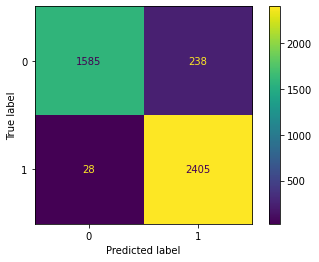

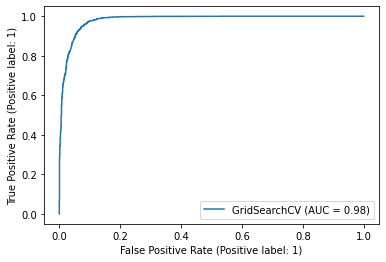

In [21]:
run_stats(gs_lr_cvec, X_train, X_test, y_train, y_test)


- `TF-ID`


In [22]:
gs_lr_tvec = run_log_reg_model(X_train, y_train, TfidfVectorizer)


C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packag


          
--------------------------------
Model Best Score:
	0.9396916350339918
          
--------------------------------
Model Best Params:
	{'lr__penalty': 'l2', 'vec__max_df': 1.0, 'vec__max_features': 3000, 'vec__min_df': 4, 'vec__stop_words': 'english'}
          
--------------------------------
Model score:
            
	Train: 95.9%
            
	Test: 93.8%
        
--------------------------------
Misclassification Rate:
            
	Train: 4.1%
            
	Test: 6.2%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.91      0.99      0.95      4939
           0       0.98      0.87      0.93      3700

    accuracy                           0.94      8639
   macro avg       0.95      0.93      0.94      8639
weighted avg       0.94      0.94      0.94      8639

Confidence interval is : 93.97 ± 0.01
Spec: 0.8661546900713111
Sens: 0.9917796958487464


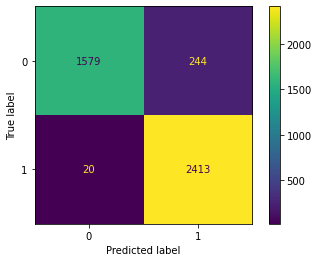

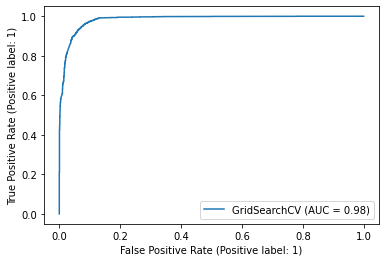

In [23]:
run_stats(gs_lr_tvec, X_train, X_test, y_train, y_test)


`KNN` Modeling


- `TF-ID`


In [24]:
def knn_model(X_train, y_train, vectorizer):
    pipe = Pipeline(
        [
            ("vec", vectorizer()),
            ("ss", StandardScaler(with_mean=False)),
            ("knn", KNeighborsClassifier()),
        ]
    )

    pipe_params = {
        "vec__max_features": [2000, 3000, 4000],
        "vec__stop_words": [None, "english"],
        "vec__min_df": [2, 4],
        "vec__max_df": [1.0, 0.8, 0.5],
        "knn__n_neighbors": [3, 5, 11],
    }

    # Init grid
    gs = global_grid_search_cv(pipe, pipe_params)

    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)

    return gs


def run_knn_model(X_train, y_train, vectorizer):
    gs_knn_tvec = knn_model(X_train, y_train, vectorizer)

    return gs_knn_tvec


In [25]:
gs_knn_tvec = run_knn_model(X_train, y_train, TfidfVectorizer)



          
--------------------------------
Model Best Score:
	0.6876926778399708
          
--------------------------------
Model Best Params:
	{'knn__n_neighbors': 3, 'vec__max_df': 1.0, 'vec__max_features': 2000, 'vec__min_df': 2, 'vec__stop_words': 'english'}
          
--------------------------------
Model score:
            
	Train: 77.9%
            
	Test: 68.1%
        
--------------------------------
Misclassification Rate:
            
	Train: 22.1%
            
	Test: 31.9%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.66      0.93      0.77      4939
           0       0.80      0.36      0.50      3700

    accuracy                           0.69      8639
   macro avg       0.73      0.65      0.64      8639
weighted avg       0.72      0.69      0.66      8639

Confidence interval is : 68.91 ± 0.06
Spec: 0.3483269336258914
Sens: 0.9309494451294698


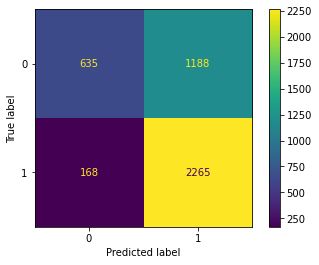

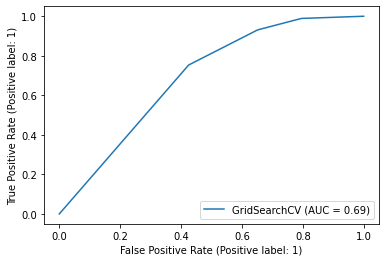

In [26]:
run_stats(gs_knn_tvec, X_train, X_test, y_train, y_test)


---

`D`ecision Tree Model


In [27]:
def decision_tree_model(X_train, y_train, vectorizer):
    pipe = Pipeline(
        [
            ("vec", vectorizer()),
            ("dt", DecisionTreeClassifier()),
        ]
    )

    pipe_params = {
        "vec__max_features": [2000, 3000, 4000, 5000],
        "vec__min_df": [2, 3],
        "vec__max_df": [0.9, 0.95],
        "vec__ngram_range": [(1, 1), (2, 2)],
        "vec__stop_words": [None, "english", stopwords.words("english")],
        "dt__max_depth": [5, 7, 9],
        "dt__min_samples_leaf": [3, 5, 7],
        "dt__min_samples_split": [7, 10],
        "dt__ccp_alpha": [0.01],
    }

    # Init grid
    gs = global_grid_search_cv(pipe, pipe_params)

    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)

    return gs


def run_dt_model(X_train, y_train, vectorizer):
    return decision_tree_model(X_train, y_train, vectorizer)


In [28]:
gs_dt_tvec = run_dt_model(X_train, y_train, TfidfVectorizer)



          
--------------------------------
Model Best Score:
	0.8634099755516953
          
--------------------------------
Model Best Params:
	{'dt__ccp_alpha': 0.01, 'dt__max_depth': 5, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 7, 'vec__max_df': 0.9, 'vec__max_features': 5000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1), 'vec__stop_words': None}
          
--------------------------------
Model score:
            
	Train: 86.4%
            
	Test: 85.0%
        
--------------------------------
Misclassification Rate:
            
	Train: 13.6%
            
	Test: 15.0%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.81      0.99      0.89      4939
           0       0.99      0.69      0.81      3700

    accuracy                           0.86      8639
   macro avg       0.90      0.84      0.85      8639
weighted avg       0.89      0.86      0.86      8639

Confidence interva

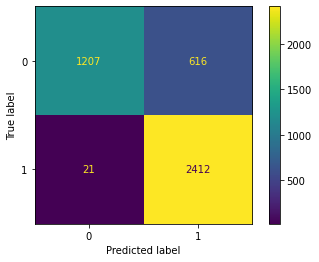

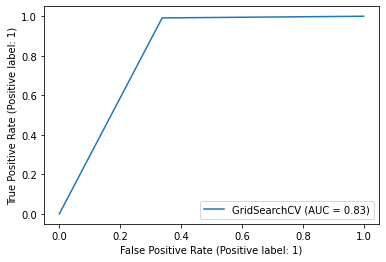

In [29]:
run_stats(gs_dt_tvec, X_train, X_test, y_train, y_test)


In [30]:
gs_dt_tvec.best_estimator_.named_steps["dt"].feature_importances_


array([0., 0., 0., ..., 0., 0., 0.])

---

`B`agging Classifier Model


In [31]:
def bagging_model(X_train, y_train, vectorizer):
    pipe = Pipeline(
        [
            ("vec", vectorizer()),
            ("bag", BaggingClassifier()),
        ]
    )

    pipe_params = {
        "vec__max_features": [2000, 3000, 4000, 5000],
        "vec__min_df": [2, 3],
        "vec__max_df": [0.9, 0.95],
        "vec__ngram_range": [(1, 1), (2, 2)],
        "vec__stop_words": [None, "english", stopwords.words("english")],
    }

    # Init grid
    gs = global_grid_search_cv(pipe, pipe_params)

    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)

    return gs


def run_bagging_model(X_train, y_train, vectorizer):
    return bagging_model(X_train, y_train, vectorizer)


In [32]:
gs_bag_tvec = bagging_model(X_train, y_train, TfidfVectorizer)



          
--------------------------------
Model Best Score:
	0.9339039948315426
          
--------------------------------
Model Best Params:
	{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 3, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}
          
--------------------------------
Model score:
            
	Train: 98.7%
            
	Test: 93.1%
        
--------------------------------
Misclassification Rate:
            
	Train: 1.3%
            
	Test: 6.9%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.93      0.96      0.94      4939
           0       0.95      0.90      0.92      3700

    accuracy                           0.93      8639
   macro avg       0.94      0.93      0.93      8639
weighted avg       0.93      0.93      0.93      8639

Confidence interval is : 93.23 ± 0.01
Spec: 0.8875479978058146
Sens: 0.9630086313193588


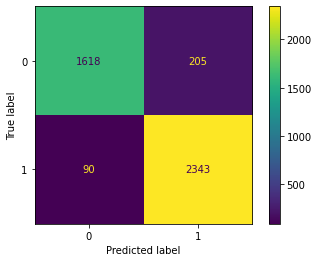

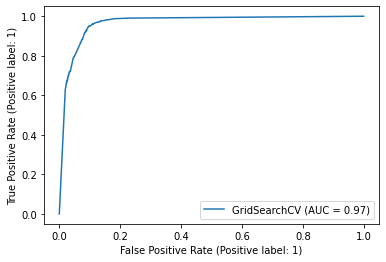

In [33]:
run_stats(gs_bag_tvec, X_train, X_test, y_train, y_test)


---

`R`andom Forest Model


In [34]:
def rft_model(X_train, y_train, vectorizer):
    pipe = Pipeline(
        [
            ("vec", vectorizer()),
            ("rft", RandomForestClassifier()),
        ]
    )

    pipe_params = {
        "vec__max_features": [2000, 3000, 4000, 5000],
        "vec__min_df": [2, 3],
        "vec__max_df": [0.9, 0.95],
        "vec__ngram_range": [(1, 1), (2, 2)],
        "vec__stop_words": [None, "english", stopwords.words("english")],
        "rft__max_depth": [5, 7, 9],
        "rft__min_samples_leaf": [3, 5, 7],
        "rft__min_samples_split": [7, 10],
        "rft__ccp_alpha": [0.01],
    }

    # Init grid
    gs = global_grid_search_cv(pipe, pipe_params)

    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)

    return gs


def run_rft_model(X_train, y_train, vectorizer):
    return rft_model(X_train, y_train, vectorizer)


In [35]:
gs_rft_tvec = rft_model(X_train, y_train, TfidfVectorizer)



          
--------------------------------
Model Best Score:
	0.8393344940916597
          
--------------------------------
Model Best Params:
	{'rft__ccp_alpha': 0.01, 'rft__max_depth': 9, 'rft__min_samples_leaf': 5, 'rft__min_samples_split': 10, 'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1), 'vec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'betw

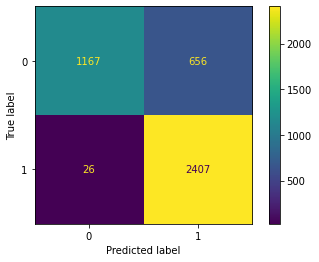

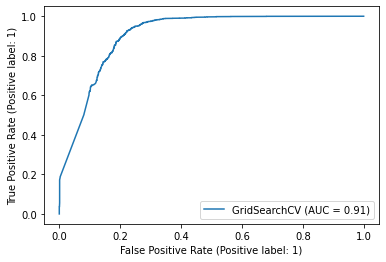

In [36]:
run_stats(gs_rft_tvec, X_train, X_test, y_train, y_test)


In [37]:
gs_rft_tvec.best_estimator_.named_steps["rft"].feature_importances_


array([0.        , 0.        , 0.        , ..., 0.00031816, 0.        ,
       0.        ])

`A`da Boost


- Estimator: `DecisionTreeClassifier`, `LogisticRegression` and `RandomForest`


In [38]:
def ada_model(X_train, y_train, vectorizer):
    pipe = Pipeline(
        [
            ("vec", vectorizer()),
            ("ada", AdaBoostClassifier()),
        ]
    )

    pipe_params = {
        "vec__max_features": [2000, 3000, 4000, 5000],
        "vec__min_df": [2, 3],
        "vec__max_df": [0.8, 0.9, 0.95],
        "vec__ngram_range": [(1, 1), (2, 2)],
        "vec__stop_words": [None, "english", stopwords.words("english")],
        "ada__n_estimators": [100, 150],
        "ada__learning_rate": [0.9, 1],
        "ada__estimator": [
            LogisticRegression(),
        ],
    }

    # Init grid
    gs = global_grid_search_cv(pipe, pipe_params)

    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)

    return gs


def run_ada_model(X_train, y_train, vectorizer):
    return ada_model(X_train, y_train, vectorizer)


In [39]:
gs_ada_tvec = ada_model(X_train, y_train, TfidfVectorizer)



          
--------------------------------
Model Best Score:
	0.8518344270732806
          
--------------------------------
Model Best Params:
	{'ada__estimator': LogisticRegression(), 'ada__learning_rate': 1, 'ada__n_estimators': 150, 'vec__max_df': 0.8, 'vec__max_features': 2000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1), 'vec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into'

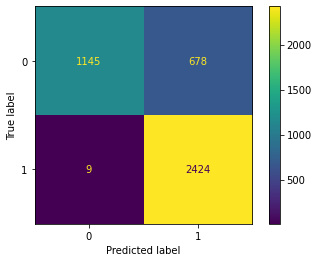

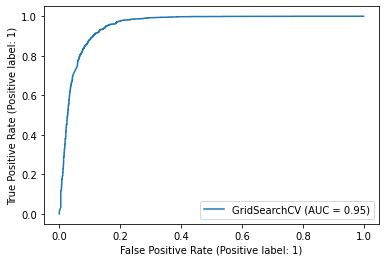

In [40]:
run_stats(gs_ada_tvec, X_train, X_test, y_train, y_test)


In [41]:
# gs_rft_tvec.best_estimator_.named_steps["ada"].feature_importances_


---

`V`oting Classifier

- Lets pick best performed models into `Voting`


In [42]:
vote = VotingClassifier(
    [
        # Naive 94/93
        ("nb", gs_nb_tfvid.best_estimator_),
        # LogReg 96/94
        ("lr", gs_lr_tvec.best_estimator_),
        # 85/85
        ("rft", gs_rft_tvec.best_estimator_),
    ]
)

vote_params = {"voting": ["hard", "soft"]}

gs_voting = GridSearchCV(vote, param_grid=vote_params, n_jobs=-1)
gs_voting.fit(X_train, y_train)


GridSearchCV(estimator=VotingClassifier(estimators=[('nb',
                                                     Pipeline(steps=[('vec',
                                                                      CountVectorizer(max_df=0.9,
                                                                                      max_features=4000,
                                                                                      min_df=3,
                                                                                      stop_words='english')),
                                                                     ('nb',
                                                                      MultinomialNB())])),
                                                    ('lr',
                                                     Pipeline(steps=[('vec',
                                                                      TfidfVectorizer(max_features=3000,
                                                                                      min_df=4,
                                                                                      stop_words='english')),
                                                                     ('lr',
                                                                      LogisticRegression())])),
                                                    ('rft',
                                                     Pipeline(steps=[('vec',
                                                                      TfidfVecto...
                                                                                                  'our',
                                                                                                  'ours',
                                                                                                  'ourselves',
                                                                                                  'you',
                                                                                                  "you're",
                                                                                                  "you've",
                                                                                                  "you'll",
                                                                                                  "you'd",
                                                                                                  'your',
                                                                                                  'yours',
                                                                                                  'yourself',
                                                                                                  'yourselves',
                                                                                                  'he',
                                                                                                  'him',
                                                                                                  'his',
                                                                                                  'himself',
                                                                                                  'she',
                                                                                                  "she's",
                                                                                                  'her',
                                                                                                  'hers',
                                                                                                  'herself',
                                                                                                  'it',
                                                                                                


          
--------------------------------
Model Best Score:
	0.9538145521027687
          
--------------------------------
Model Best Params:
	{'voting': 'soft'}
          
--------------------------------
Model score:
            
	Train: 96.3%
            
	Test: 94.4%
        
--------------------------------
Misclassification Rate:
            
	Train: 3.7%
            
	Test: 5.6%
--------------------------------

        
Classifier Report:
              precision    recall  f1-score   support

           1       0.94      0.98      0.96      4939
           0       0.97      0.92      0.94      3700

    accuracy                           0.95      8639
   macro avg       0.96      0.95      0.95      8639
weighted avg       0.95      0.95      0.95      8639

Confidence interval is : 95.34 ± 0.01
Spec: 0.9012616566099836
Sens: 0.9765721331689272


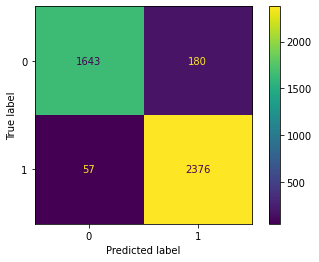

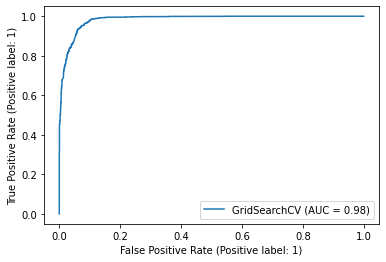

In [43]:
run_stats(gs_voting, X_train, X_test, y_train, y_test)


---

`S`tacking


In [44]:
# Create the model
level_1_estimators = [
    # Naive 94/93
    ("nb", gs_nb_tfvid.best_estimator_),
    # LogReg 96/94
    ("lr", gs_lr_tvec.best_estimator_),
    # 85/85
    ("bag", gs_bag_tvec.best_estimator_),
]

stacked_model = StackingClassifier(
    estimators=level_1_estimators, final_estimator=LogisticRegression()
)

# Fit
stacked_model.fit(X_train, y_train)


StackingClassifier(estimators=[('nb',
                                Pipeline(steps=[('vec',
                                                 CountVectorizer(max_df=0.9,
                                                                 max_features=4000,
                                                                 min_df=3,
                                                                 stop_words='english')),
                                                ('nb', MultinomialNB())])),
                               ('lr',
                                Pipeline(steps=[('vec',
                                                 TfidfVectorizer(max_features=3000,
                                                                 min_df=4,
                                                                 stop_words='english')),
                                                ('lr', LogisticRegression())])),
                               ('bag',
                                Pipeline(steps=[('vec',
                                                 TfidfVectorizer(max_df=0.9,
                                                                 max_features=4000,
                                                                 min_df=3,
                                                                 stop_words='english')),
                                                ('bag',
                                                 BaggingClassifier())]))],
                   final_estimator=LogisticRegression())

In [45]:
stacked_model.score(X_train, y_train), stacked_model.score(X_test, y_test)


(0.9771964347725431, 0.950187969924812)

**`Voting` and `Stacking` performed almost exact good performance**


---


`L`et's now add more features into model


In [46]:
tX = df[
    [
        "subreddit_text",
        "subreddit_text_word_count",
        "subreddit_text_length",
    ]
]

ty = df["subreddit"]

tX_train, tX_test, ty_train, ty_test = train_test_split(tX, ty, stratify=ty)


In [47]:
ty_train.value_counts(normalize=True)


1    0.571709
0    0.428291
Name: subreddit, dtype: float64

In [52]:
vote = VotingClassifier(
    [
        (
            "pipe_1",
            Pipeline(
                [
                    (
                        "ct",
                        make_column_transformer(
                            (
                                TfidfVectorizer(
                                    max_features=5000,
                                    max_df=0.9,
                                    ngram_range=(1, 1),
                                    stop_words="english",
                                ),
                                "subreddit_text",
                            ),
                            remainder="passthrough",
                        ),
                    ),
                    # ("nb", MultinomialNB()),
                    # ("lr", LogisticRegression()),
                    ("rft", RandomForestClassifier()),
                ]
            ),
        ),
    ]
)

vote_params = {"voting": ["hard", "soft"]}

tgs_voting = GridSearchCV(vote, param_grid=vote_params, n_jobs=-1)
tgs_voting.fit(tX_train, ty_train)


GridSearchCV(estimator=VotingClassifier(estimators=[('pipe_1',
                                                     Pipeline(steps=[('ct',
                                                                      ColumnTransformer(remainder='passthrough',
                                                                                        transformers=[('tfidfvectorizer',
                                                                                                       TfidfVectorizer(max_df=0.9,
                                                                                                                       max_features=5000,
                                                                                                                       stop_words='english'),
                                                                                                       'subreddit_text')])),
                                                                     ('rft',
                                                                      RandomForestClassifier())]))]),
             n_jobs=-1, param_grid={'voting': ['hard', 'soft']})

In [55]:
tgs_voting.score(tX_train, ty_train), tgs_voting.score(tX_test, ty_test)

(0.9980353634577603, 0.9491315136476427)

In [54]:
cross_val_score(tgs_voting.best_estimator_, tX_train, ty_train, cv=5).mean()


0.9397173922918854

> Adding additional features `overfits` our model


---

`A`dd sentiment to dataframe


In [56]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()


def create_polarity_scores(df, target):
    new_col = target + "_sent_"
    df[new_col + "neg"] = df[target].map(lambda text: sent.polarity_scores(text)["neg"])
    df[new_col + "neu"] = df[target].map(lambda text: sent.polarity_scores(text)["neu"])
    df[new_col + "pos"] = df[target].map(lambda text: sent.polarity_scores(text)["pos"])
    df[new_col + "compound"] = df[target].map(
        lambda text: sent.polarity_scores(text)["compound"]
    )


create_polarity_scores(df, "subreddit_text")

df.head(1)


,selftext,title,score,domain,id,author,num_comments,url,created_utc,subreddit,...,selftext_emoji_count,title_emoji_count,subreddit_text,subreddit_text_length,subreddit_text_word_count,subreddit_text_emoji_count,subreddit_text_sent_neg,subreddit_text_sent_neu,subreddit_text_sent_pos,subreddit_text_sent_compound
0,"If I wanted to play a virtual board game remotely with someone who didn't have a great PC but could still Zoom/Skype, what would you recommend? Any direction you can provide would be massively appreciated.&amp;#x200B;Here's the scenario I'd like to discover a solution for:* A roleplay game I can essentially DM on one side - She says ""Let's move here"" and I can adjust the tokens on both turns. ...",Virtual board games you can host over Zoom?,1,self.boardgames,105yauz,TylerDeLarm,0,https://www.reddit.com/r/boardgames/comments/105yauz/virtual_board_games_you_can_host_over_zoom/,1673122098,0,...,0,0,if i wanted to play a virtual board game remotely with someone who didnt have a great pc but could still zoom skype what would you remend any direction you can provide would be massively appreciated heres the scenario id like to discover a solution for a roleplay game i can essentially dm on one side she says lets move here...,684,120,0,0.016,0.758,0.226,0.9822


---

`O`utput data


In [57]:
df.to_csv("../data/ready_data/reddit_data.csv", index=False)
